In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy as np
import pandas as pd
import keras
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.utils import normalize
from sklearn.utils import class_weight
from keras.metrics import MeanIoU
import imageio
from PIL import Image
from numpy import asarray
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
%matplotlib inline

Segmentation Models: using `tf.keras` framework.


In [4]:
path = '/content/drive/MyDrive/Road_Anamoly_semantic_segmentation/'
image_path = os.path.join(path, 'images/')
mask_path = os.path.join(path, 'masks/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [5]:
image_list = sorted(image_list)
mask_list = sorted(mask_list)

In [6]:
len(image_list)

950

In [7]:
len(mask_list)

950

<ipython-input-8-ea89fe30e804>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
<ipython-input-8-ea89fe30e804>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

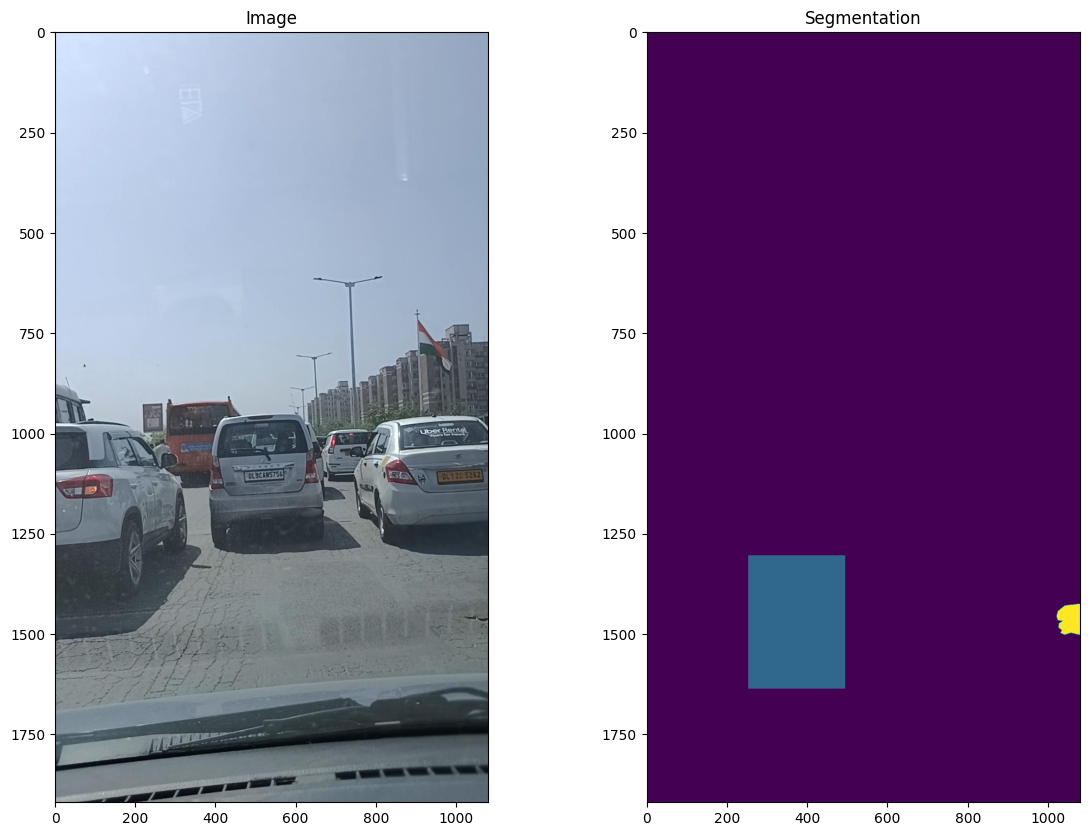

In [8]:
N = 3
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)#[:, :, 0])
arr[1].set_title('Segmentation')

In [9]:
images = []
for i in range(len(image_list)):
    img = Image.open(image_list[i])
    img = img.resize((256, 256))
    img = asarray(img)
    images.append(img)

In [10]:
masks = []
for i in range(len(mask_list)):
    mask = Image.open(mask_list[i])
    mask = mask.resize((256, 256))
    mask = asarray(mask)
    masks.append(mask)

In [11]:
images = np.array(images)
masks = np.array(masks)

(950, 256, 256, 3)


Text(0.5, 1.0, 'Segmentation')

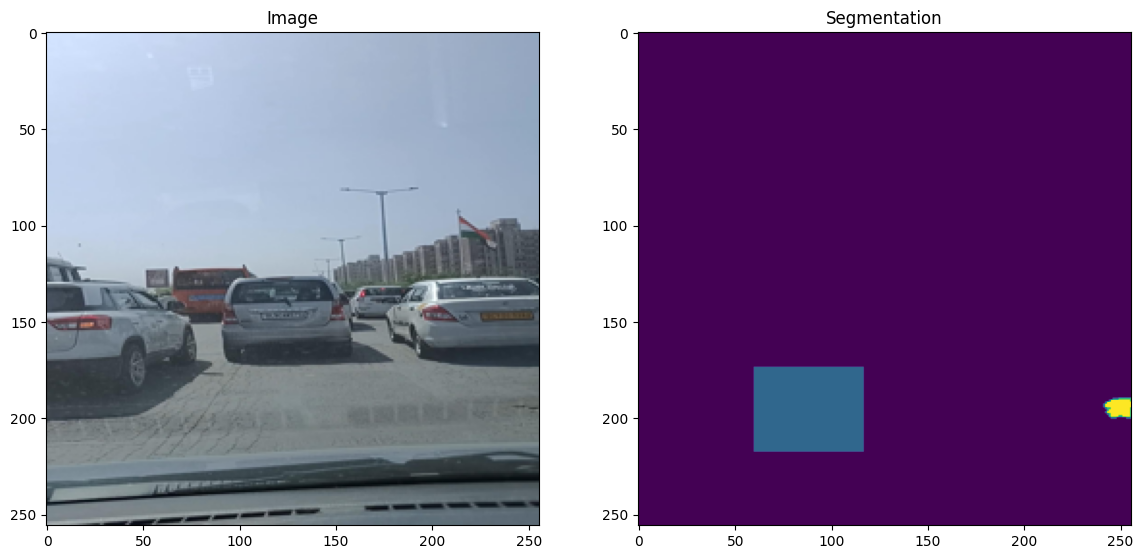

In [26]:
image = images[3]
mask = masks[3]
print(images.shape)
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(image)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

In [13]:
def mask_to_categorical(masks, n_classes):
  print(np.unique(masks))
  masks_cat = to_categorical(masks, num_classes = n_classes)
  print(masks_cat.shape)
  print(np.unique(masks_cat))
  return masks_cat

In [14]:
masks_cat = mask_to_categorical(masks, 7)

[0 1 2 3 4 5 6]
(950, 256, 256, 7)
[0. 1.]


In [15]:
def get_class_weights(y):
  classes = y.reshape(-1)
  class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                    classes = np.unique(classes),
                                                    y = classes)
  print(class_weights.shape)
  return class_weights

In [16]:
class_weights = get_class_weights(masks)

(7,)


In [17]:
class_weights

array([1.47473023e-01, 1.78890223e+01, 4.13320976e+01, 5.49219562e+01,
       8.83002132e+00, 2.36120087e+02, 3.01978455e+02])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(images, masks_cat, test_size=0.2)

In [19]:
#Model Training

In [20]:
#metrics
import keras.backend as K
def dice_coef(y_true, y_pred, smooth=1):

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [59]:
n_classes=7
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

class_weights = list(class_weights)
print(len(class_weights))
# dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)
total_loss = focal_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), 'accuracy', dice_coef]

7


In [60]:
BACKBONE1 = 'resnet18'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

In [61]:
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

In [62]:
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

In [63]:
model1.compile(optim, total_loss, metrics=metrics)
model1.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_36 (ZeroPad  (None, None, None, 3)        0         ['bn_data[0][0]']             
 ding2D)                                                                                          
                                                                                            

In [64]:
history1= model1.fit(X_train1,
          y_train,
          batch_size=8,
          epochs=120,
          verbose=1,
          validation_data=(X_test1, y_test))

Epoch 1/120
95/95 [==============================] - 26s 153ms/step - loss: 0.0344 - iou_score: 0.0559 - f1-score: 0.0576 - accuracy: 0.7482 - dice_coef: 0.6928 - val_loss: 0.0285 - val_iou_score: 0.0887 - val_f1-score: 0.0985 - val_accuracy: 0.9368 - val_dice_coef: 0.7207
Epoch 2/120
95/95 [==============================] - 13s 142ms/step - loss: 0.0122 - iou_score: 0.0244 - f1-score: 0.0336 - accuracy: 0.9626 - dice_coef: 0.8205 - val_loss: 0.0172 - val_iou_score: 0.0347 - val_f1-score: 0.0442 - val_accuracy: 0.9566 - val_dice_coef: 0.7890
Epoch 3/120
95/95 [==============================] - 13s 141ms/step - loss: 0.0066 - iou_score: 0.1546 - f1-score: 0.1646 - accuracy: 0.9673 - dice_coef: 0.8825 - val_loss: 0.0073 - val_iou_score: 0.1542 - val_f1-score: 0.1694 - val_accuracy: 0.9643 - val_dice_coef: 0.8767
Epoch 4/120
95/95 [==============================] - 13s 138ms/step - loss: 0.0043 - iou_score: 0.2311 - f1-score: 0.2349 - accuracy: 0.9690 - dice_coef: 0.9198 - val_loss: 0.004

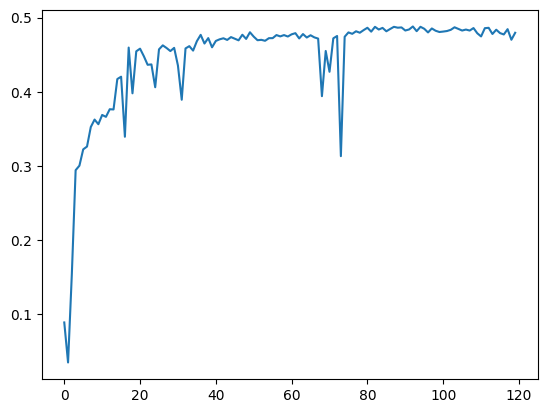

In [65]:
plt.plot(history1.history["val_iou_score"])

In [66]:
import pandas as pd
from google.colab import files
df = pd.DataFrame(history1.history)
df.to_excel('UNetBackbone_NewApproach.xlsx')
files.download('UNetBackbone_NewApproach.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
model1.save('resnet18Unet.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [68]:
files.download('resnet18Unet.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import random

In [74]:
#Y_predict = model1.predict(X_train, verbose=1)

In [69]:
def add_color(img):
  img = img.reshape(256, 256, 1)
  frame = np.concatenate((img, img, img), axis=2)
  width = frame.shape[0]
  height = frame.shape[1]
  for x in range(width):
    for y in range(height):
      b, g, r = frame[x, y]
      if (b, g, r) == (0,0,0): #background
        frame[x, y] = (0,0,0)
      elif (b, g, r) == (1,1,1): #roadAsphalt
        frame[x, y] = (85,85,255)
      elif (b, g, r) == (2,2,2): #roadPaved
        frame[x, y] = (85,170,127)
      elif (b, g, r) == (3,3,3): #roadUnpaved
        frame[x, y] = (255,170,127)
      elif (b, g, r) == (4,4,4): #roadMarking
        frame[x, y] = (255,255,255)
      elif (b, g, r) == (5,5,5): #speedBump
        frame[x, y] = (255,85,255)
      elif (b, g, r) == (6,6,6): #catsEye
        frame[x, y] = (255,255,127)
      elif (b, g, r) == (7,7,7): #stormDrain
        frame[x, y] = (170,0,127)
      elif (b, g, r) == (8,8,8): #manholeCover
        frame[x, y] = (0,255,255)
      elif (b, g, r) == (9,9,9): #patchs
        frame[x, y] = (0,0,127)
      elif (b, g, r) == (10,10,10): #waterPuddle
        frame[x, y] = (170,0,0)
      elif (b, g, r) == (11,11,11): #pothole
        frame[x, y] = (255,0,0)
      elif (b, g, r) == (12,12,12): #cracks
        frame[x, y] = (255,85,0)
  return frame

In [67]:
# train_ids = next(os.walk('/content/drive/MyDrive/Road_Anamoly_semantic_segmentation/images'))
# test_ids = next(os.walk('/content/drive/MyDrive/Road_Anamoly_semantic_segmentation/images'))
# # Check predict data
# f, axarr = plt.subplots(2,3)
# f.set_size_inches(20,10)
# ix = 27 #random.randint(0, len(train_ids[2]))
# axarr[0,0].imshow(X_train[ix])
# axarr[0,0].set_title('Microscope')
# axarr[0,1].imshow(add_color(np.squeeze(Y_predict[ix])))
# axarr[0,1].set_title('"Predicted" Masks')
# axarr[0,2].imshow(np.squeeze(y_train[ix]))
# axarr[0,2].set_title('"GroundTruth" Masks')

# axarr[1,0].imshow(X_train[ix])
# axarr[1,0].set_title('Microscope')
# axarr[1,1].imshow(add_color(np.squeeze(Y_predict[ix])))
# axarr[1,1].set_title('"Predicted" Masks')
# axarr[1,2].imshow(np.squeeze(y_train[ix]))
# axarr[1,2].set_title('"GroundTruth" Masks')

# plt.show()

In [70]:
def get_prediction(img):
  img = img.reshape(1, 256, 256, 3)
  y_pred = model1.predict(img)
  y_pred = np.argmax(y_pred, axis=3)
  y_pred = y_pred.reshape(256, 256)
  return y_pred

1/1 [==============================] - 1s 511ms/step


Text(0.5, 1.0, 'Masked')

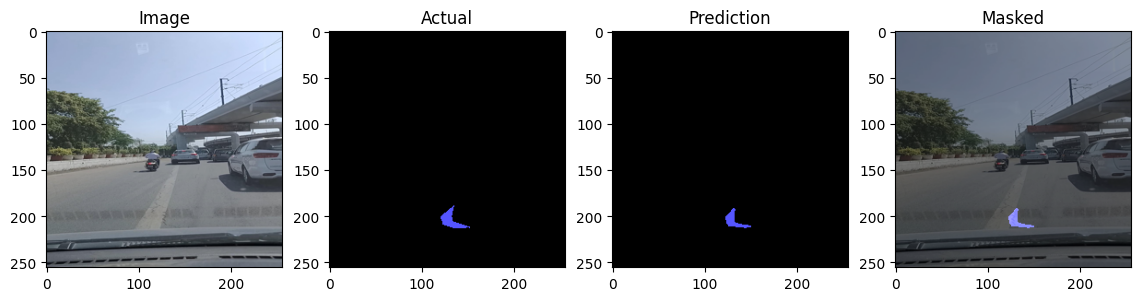

In [71]:
ix = 27
Y_pred = get_prediction(images[ix])
pred = add_color(Y_pred)
pred = pred.astype('uint8')
fig, arr = plt.subplots(1, 4, figsize=(14, 10))
arr[0].imshow(images[ix])
arr[0].set_title('Image')
arr[1].imshow(add_color(masks[ix]))
arr[1].set_title('Actual')
arr[2].imshow(pred)
arr[2].set_title('Prediction')
arr[3].imshow(cv2.addWeighted(images[ix], 0.6, pred, 0.8, 1))
arr[3].set_title('Masked')

1/1 [==============================] - 0s 23ms/step


Text(0.5, 1.0, 'Masked')

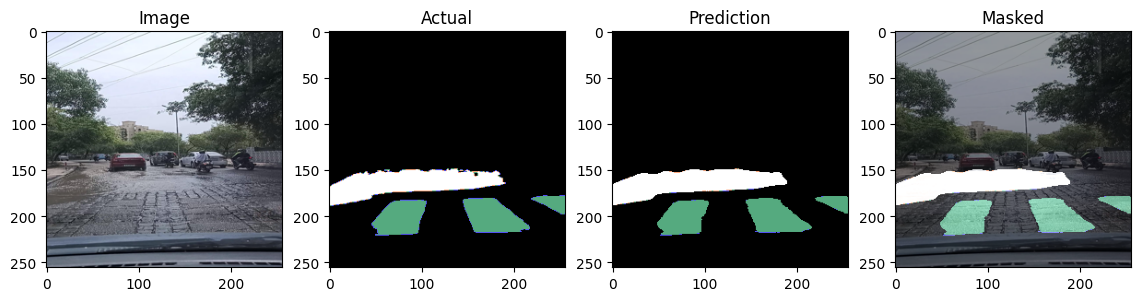

In [72]:
ix = 175
Y_pred = get_prediction(images[ix])
pred = add_color(Y_pred)
pred = pred.astype('uint8')
fig, arr = plt.subplots(1, 4, figsize=(14, 10))
arr[0].imshow(images[ix])
arr[0].set_title('Image')
arr[1].imshow(add_color(masks[ix]))
arr[1].set_title('Actual')
arr[2].imshow(pred)
arr[2].set_title('Prediction')
arr[3].imshow(cv2.addWeighted(images[ix], 0.6, pred, 0.8, 1))
arr[3].set_title('Masked')

1/1 [==============================] - 0s 23ms/step


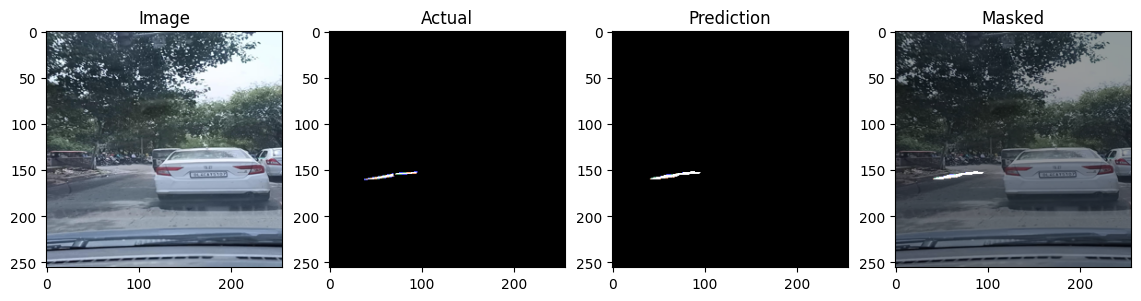

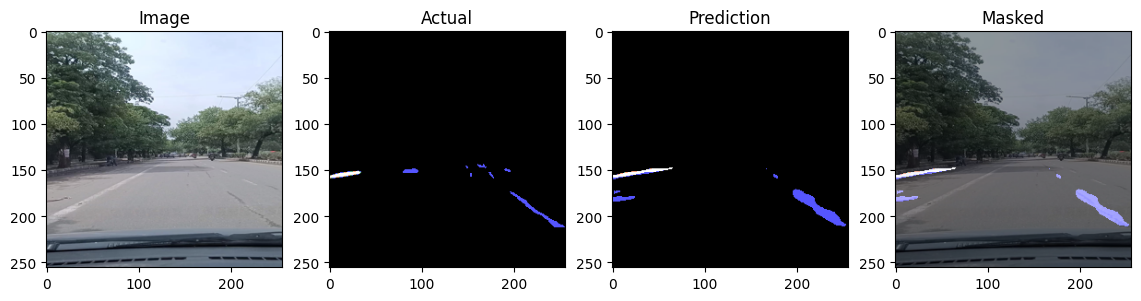

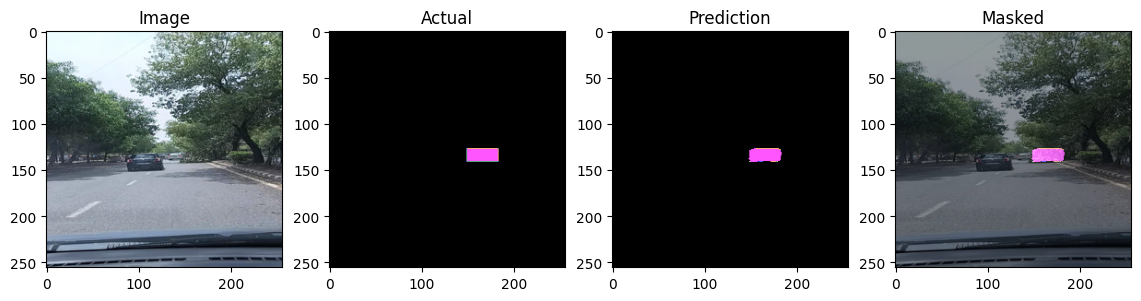

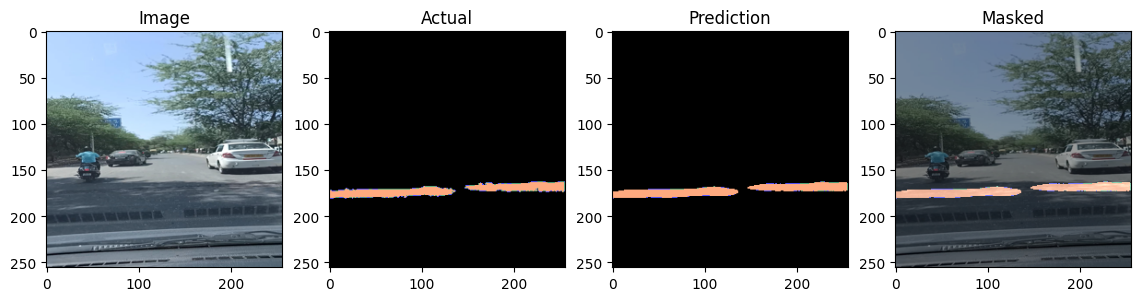

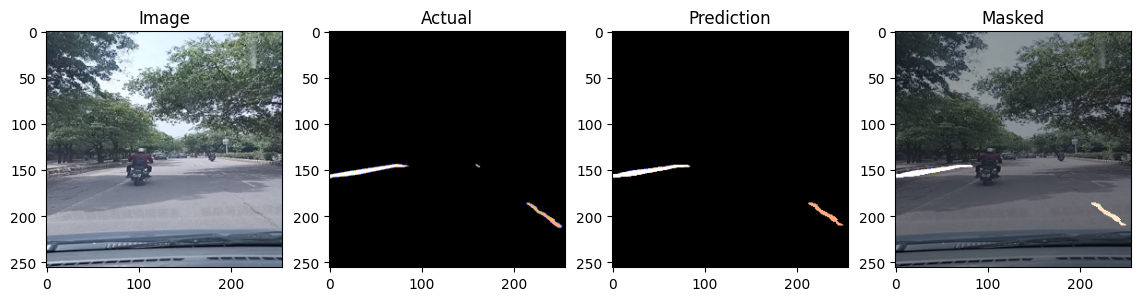

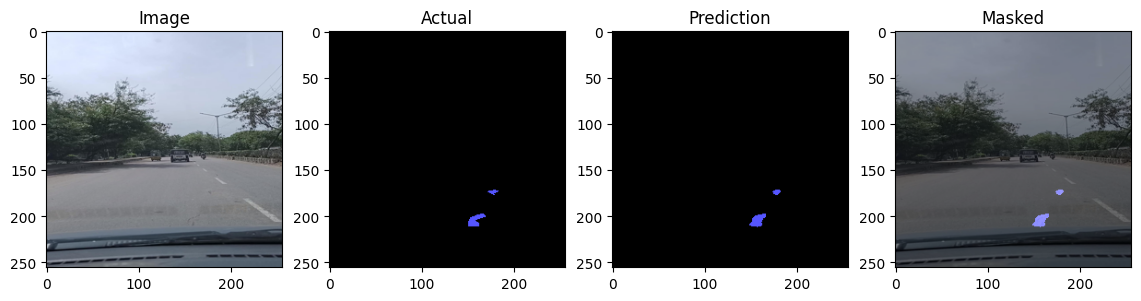

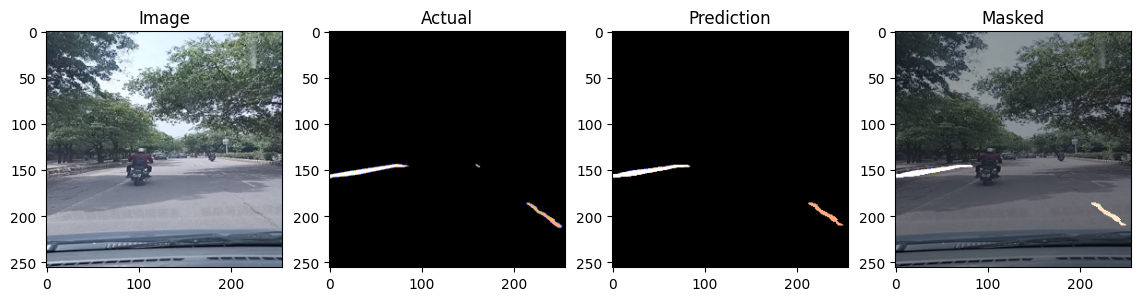

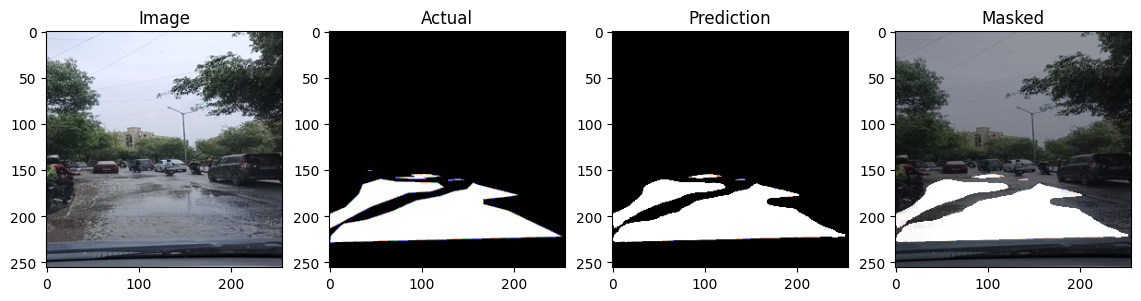

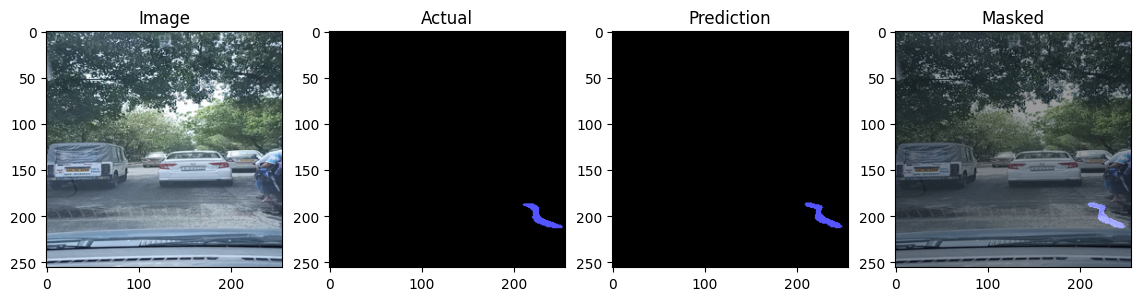

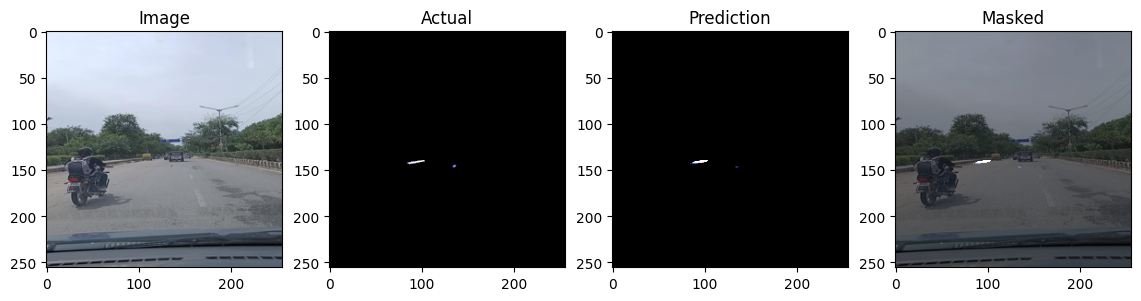

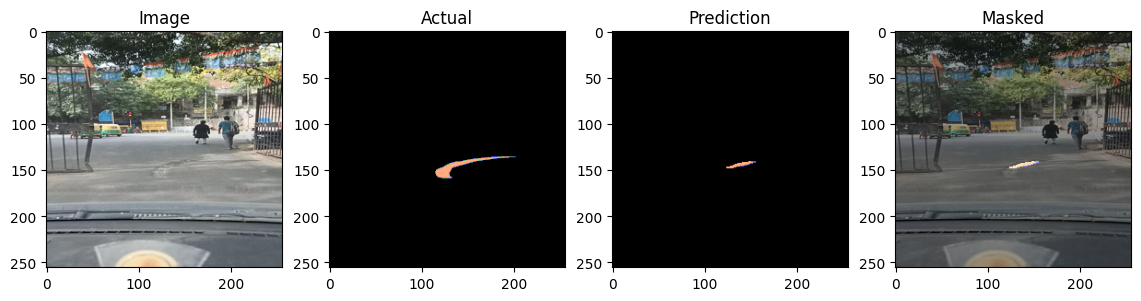

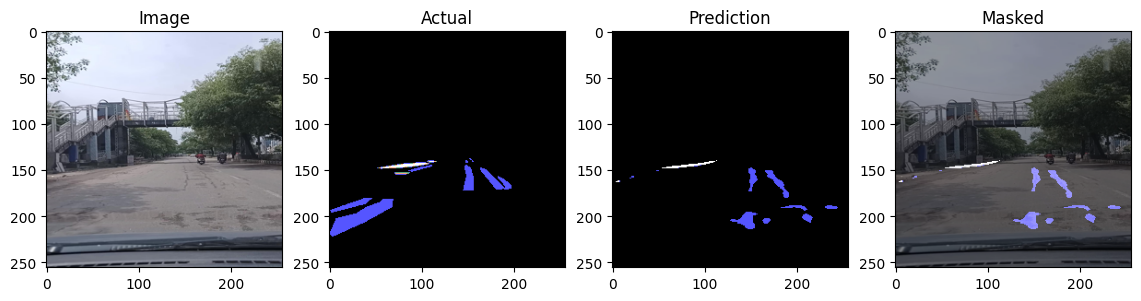

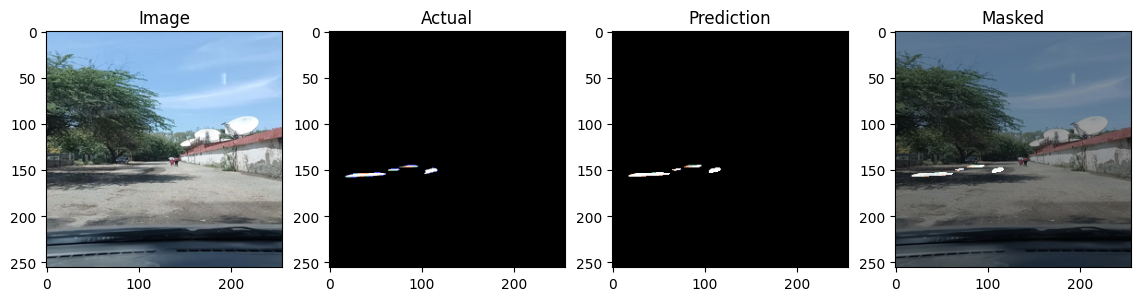

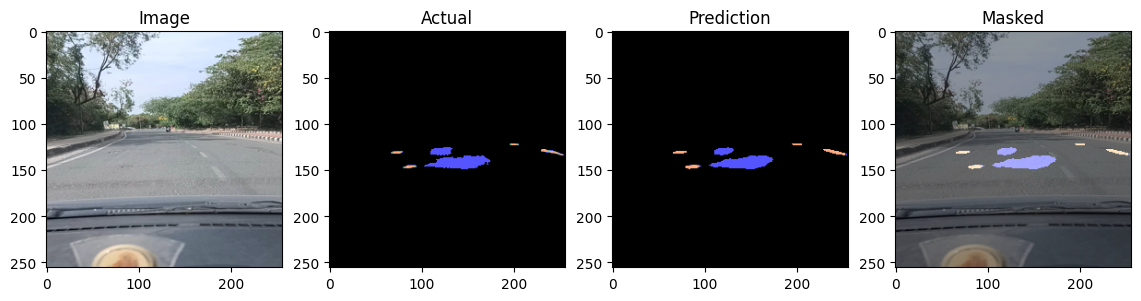

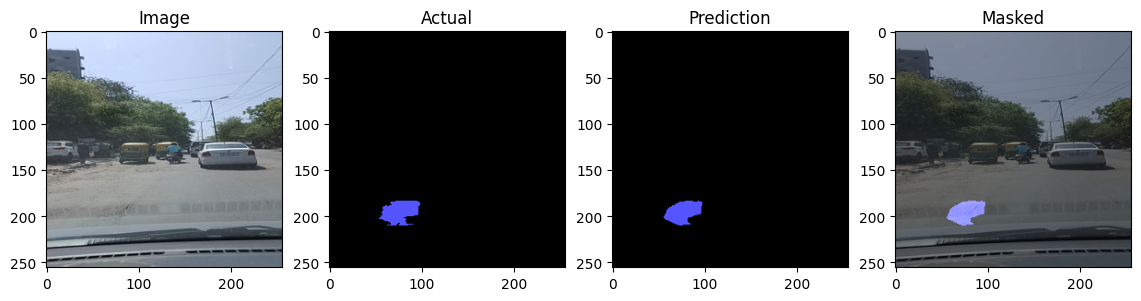

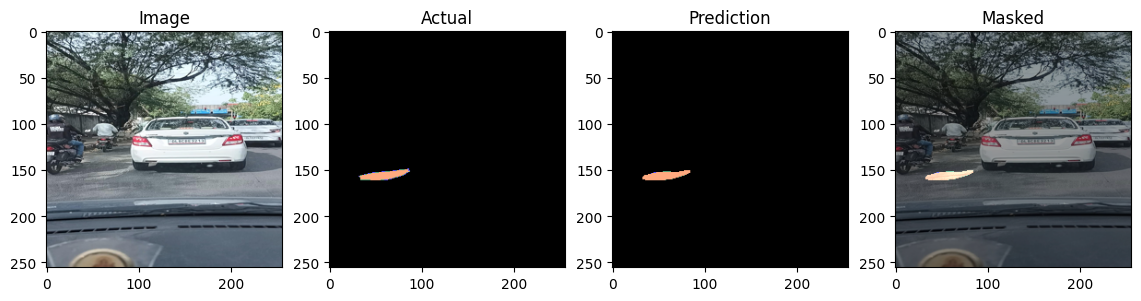

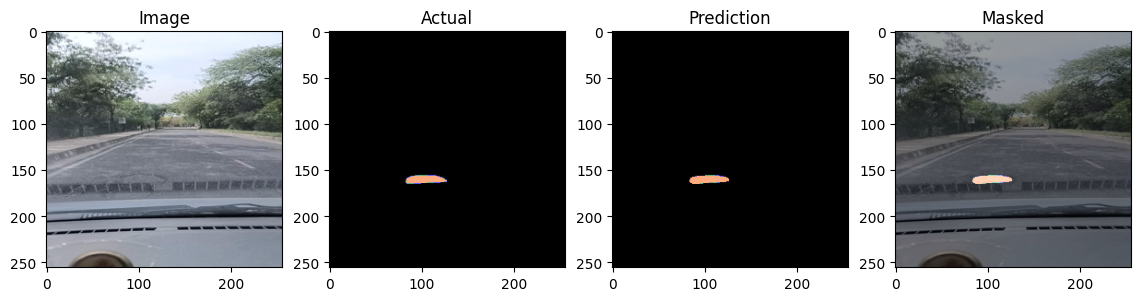

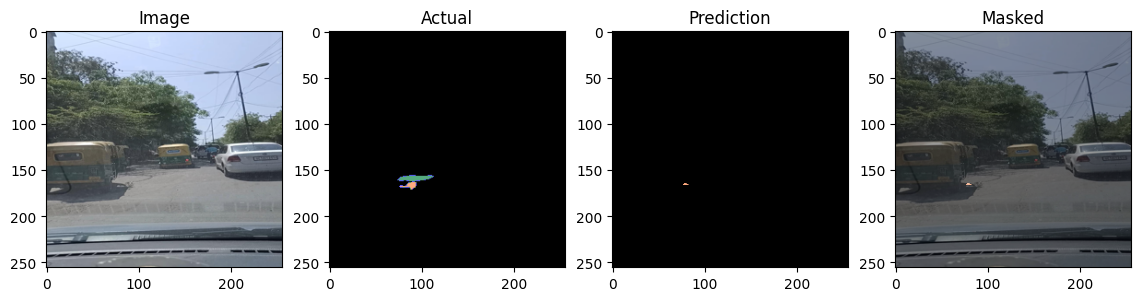

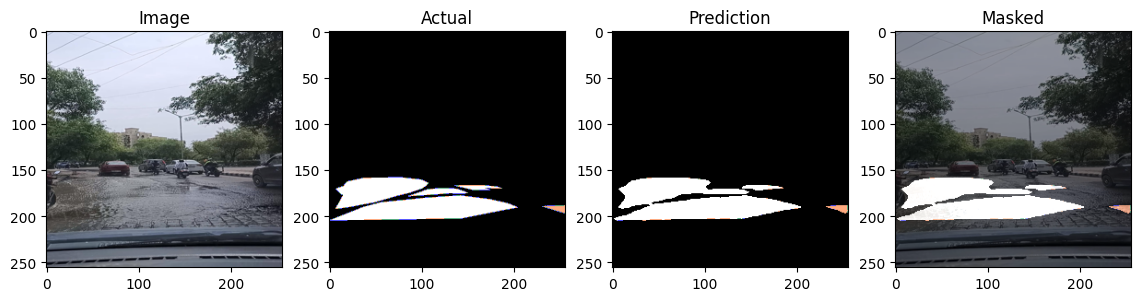

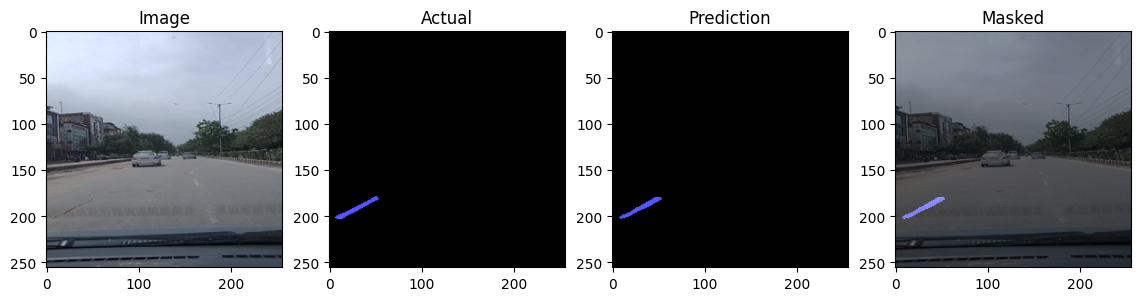

In [73]:
import random
for i in range(20):
   # generating a random number in the range 1 to 100
   r=random.randint(1,500)
   ix = r
   Y_pred = get_prediction(images[ix])
   pred = add_color(Y_pred)
   pred = pred.astype('uint8')
   fig, arr = plt.subplots(1, 4, figsize=(14, 10))
   arr[0].imshow(images[ix])
   arr[0].set_title('Image')
   arr[1].imshow(add_color(masks[ix]))
   arr[1].set_title('Actual')
   arr[2].imshow(pred)
   arr[2].set_title('Prediction')
   arr[3].imshow(cv2.addWeighted(images[ix], 0.6, pred, 0.8, 1))
   arr[3].set_title('Masked')

In [74]:
df = pd.DataFrame(history1.history)


In [75]:
df.head()

loss  iou_score  f1-score  accuracy  dice_coef  val_loss  \
0  0.034376   0.055898  0.057567  0.748190   0.692809  0.028499   
1  0.012192   0.024362  0.033565  0.962641   0.820512  0.017234   
2  0.006646   0.154574  0.164577  0.967341   0.882503  0.007283   
3  0.004324   0.231142  0.234895  0.968968   0.919826  0.004241   
4  0.003220   0.275266  0.285429  0.974357   0.939972  0.003324   

   val_iou_score  val_f1-score  val_accuracy  val_dice_coef  
0       0.088742      0.098458      0.936832       0.720709  
1       0.034729      0.044207      0.956550       0.789003  
2       0.154236      0.169411      0.964256       0.876686  
3       0.294172      0.298703      0.970771       0.919487  
4       0.300297      0.303893      0.970699       0.939686

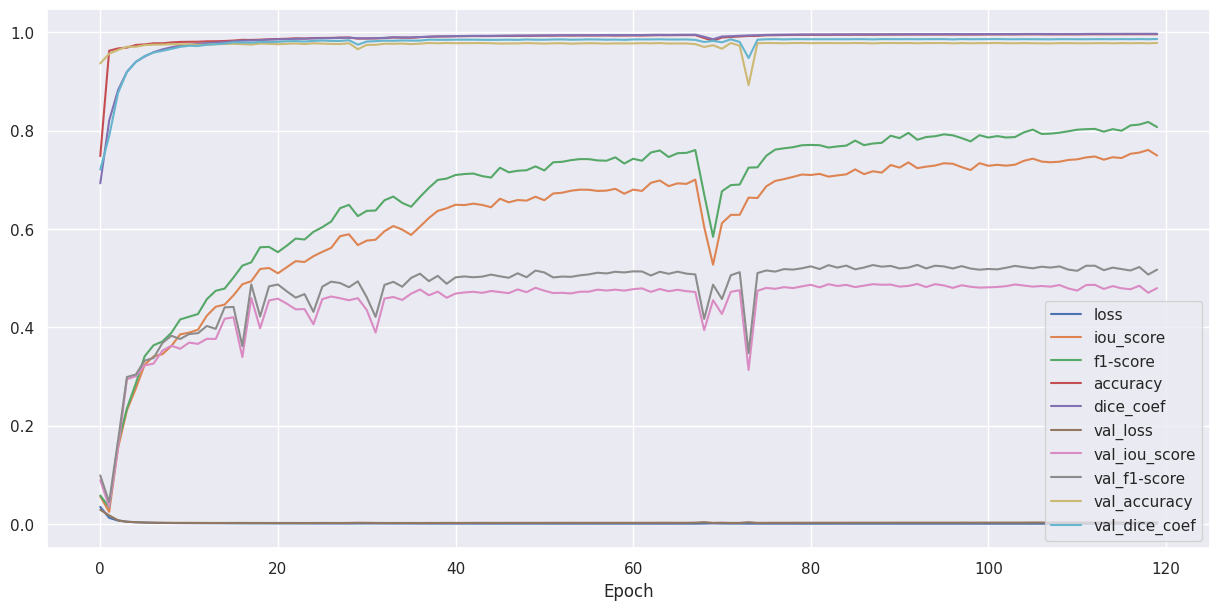

In [76]:
import seaborn as sns
sns.set_theme()
pd.DataFrame(history1.history).plot(figsize=(15, 7))
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()

In [ ]:
n_classes=7
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

class_weights = list(class_weights)
print(len(class_weights))
# dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)
total_loss = focal_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), 'accuracy', dice_coef]

In [100]:
#VGG 16

In [45]:
BACKBONE5 = 'vgg16'
preprocess_input2 = sm.get_preprocessing(BACKBONE5)

In [46]:
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

In [47]:
model2 = sm.Unet(BACKBONE5, encoder_weights='imagenet', classes=n_classes, activation=activation)

58889256/58889256 [==============================] - 0s 0us/step


In [53]:
model2.compile(optim, total_loss, metrics)
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, None, None, 64)       36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, None, None, 64)       0         ['block1_conv2[0][0]']        
                                                                                            

In [54]:
history2 = model2.fit(X_train2,
          y_train,
          batch_size=8,
          epochs=120,
          verbose=1,
          validation_data=(X_test2, y_test))

Epoch 1/120


StagingError: ignored

In [ ]:
plt.plot(history2.history["val_iou_score"])

In [ ]:
model2.save('vggUnet.hdf5')
#from google.colab import files
files.download('vggUnet.hdf5')

In [50]:
import pandas as pd
from google.colab import files
df = pd.DataFrame(history2.history)
df.to_excel('UNetBackbone_NewApproach_vgg16.xlsx')
files.download('UNetBackbone_NewApproach_vgg16.xlsx')

NameError: ignored

In [51]:
def get_prediction(img):
  img = img.reshape(1, 256, 256, 3)
  y_pred = model2.predict(img)
  y_pred = np.argmax(y_pred, axis=3)
  y_pred = y_pred.reshape(256, 256)
  return y_pred

1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'Masked')

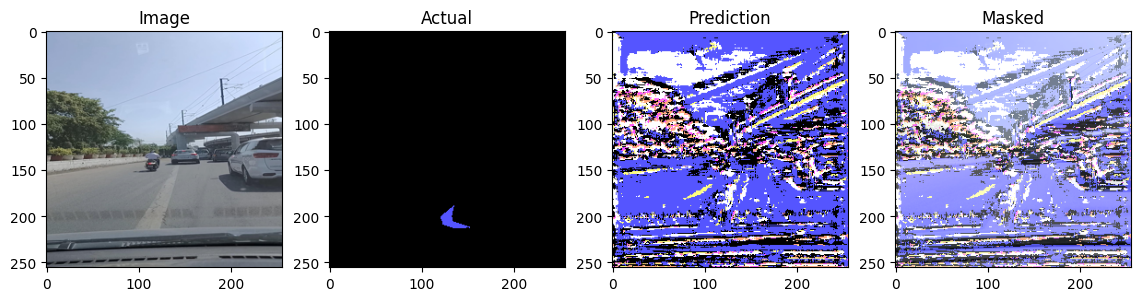

In [52]:
ix = 27
Y_pred = get_prediction(images[ix])
pred = add_color(Y_pred)
pred = pred.astype('uint8')
fig, arr = plt.subplots(1, 4, figsize=(14, 10))
arr[0].imshow(images[ix])
arr[0].set_title('Image')
arr[1].imshow(add_color(masks[ix]))
arr[1].set_title('Actual')
arr[2].imshow(pred)
arr[2].set_title('Prediction')
arr[3].imshow(cv2.addWeighted(images[ix], 0.6, pred, 0.8, 1))
arr[3].set_title('Masked')

1/1 [==============================] - 0s 23ms/step


Text(0.5, 1.0, 'Masked')

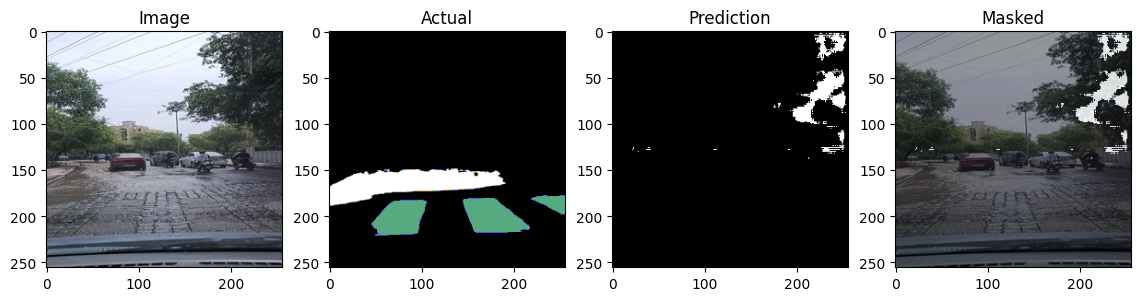

In [119]:
ix = 175
Y_pred = get_prediction(images[ix])
pred = add_color(Y_pred)
pred = pred.astype('uint8')
fig, arr = plt.subplots(1, 4, figsize=(14, 10))
arr[0].imshow(images[ix])
arr[0].set_title('Image')
arr[1].imshow(add_color(masks[ix]))
arr[1].set_title('Actual')
arr[2].imshow(pred)
arr[2].set_title('Prediction')
arr[3].imshow(cv2.addWeighted(images[ix], 0.6, pred, 0.8, 1))
arr[3].set_title('Masked')